# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

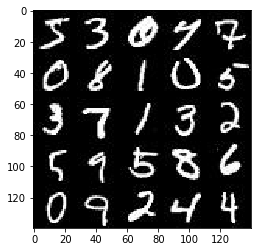

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

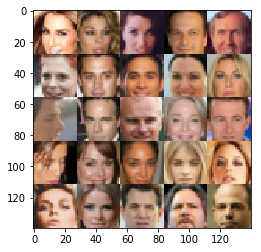

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\ProgramData\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests
from scipy.stats import truncnorm
    
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_image = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="inputs_image")
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="inputs_z")
    lr = tf.placeholder(tf.float32, name="lr")
    return inputs_image, inputs_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
from functools import reduce

def discriminator(images, reuse=False):
    
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)

    """

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        # 1st layer, where leaky relu has the hyperparameter 0.1 and it is different from other layers
        # if you modify any hyperparameter below, it is highly probable that you cannot get the result
        # also, the first layer should not add batch_normalization, which is mentioned in the video while reason is not cleared
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        conv2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        conv3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(relu3, rate=0.5)
        
        flat = tf.reshape(dropout3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)  
        
    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
            
    """
        
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        alpha = 0.1
        drop = 0.5 if is_train is True else 1.0
            
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate=drop)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate=drop)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate=drop)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    d_logits_real, out = discriminator(input_real, reuse=False)
    d_logits_fake, out = discriminator(input_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=(tf.zeros_like(d_logits_real) + .1)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake) * (1 - smooth)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # not sure the meaning
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z =  truncnorm(-1, 1).rvs(size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    image_width, image_height, image_channels = data_shape[1:]  
    
    inputs_image, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_image, inputs_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    samples, losses = [], []
    print_every = 10
    show_every = 100
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = truncnorm(-1, 1).rvs(size=[batch_size, z_dim]) # the size here refer to output size
                _ = sess.run(d_train_opt, feed_dict={inputs_image: batch_images, inputs_z: batch_z, lr:learning_rate})
                # why I need to add inputs_image in g_loss? if not, error would be reported
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate, inputs_image:batch_images}) 
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_image: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1) L
Epoch 1/2... Discriminator Loss: 0.8593... Generator Loss: 2.1086
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 0.8374
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 2.5643
Epoch 1/2... Discriminator Loss: 2.0877... Generator Loss: 0.3399
Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 3.9341
Epoch 1/2... Discriminator Loss: 0.8392... Generator Loss: 3.4454
Epoch 1/2... Discriminator Loss: 0.7557... Generator Loss: 1.3846
Epoch 1/2... Discriminator Loss: 0.7533... Generator Loss: 2.0474
Epoch 1/2... Discriminator Loss: 1.6071... Generator Loss: 0.4172
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 0.9670


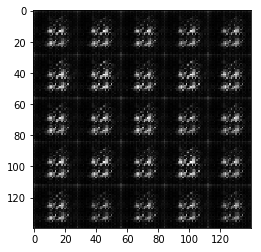

Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 2.4332
Epoch 1/2... Discriminator Loss: 0.7220... Generator Loss: 1.6266
Epoch 1/2... Discriminator Loss: 0.7321... Generator Loss: 1.5552
Epoch 1/2... Discriminator Loss: 0.6946... Generator Loss: 1.7838
Epoch 1/2... Discriminator Loss: 0.6894... Generator Loss: 2.2162
Epoch 1/2... Discriminator Loss: 0.6830... Generator Loss: 1.7366
Epoch 1/2... Discriminator Loss: 0.6689... Generator Loss: 1.9799
Epoch 1/2... Discriminator Loss: 0.7288... Generator Loss: 1.4283
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 1.5283
Epoch 1/2... Discriminator Loss: 0.7578... Generator Loss: 3.2264


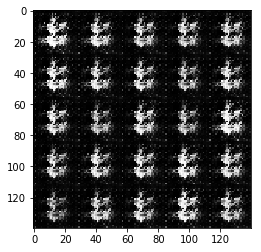

Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 0.8396
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 0.7756
Epoch 1/2... Discriminator Loss: 0.7215... Generator Loss: 1.5471
Epoch 1/2... Discriminator Loss: 0.7494... Generator Loss: 1.4494
Epoch 1/2... Discriminator Loss: 0.7685... Generator Loss: 1.3262
Epoch 1/2... Discriminator Loss: 0.7229... Generator Loss: 1.4035
Epoch 1/2... Discriminator Loss: 0.6786... Generator Loss: 2.1512
Epoch 1/2... Discriminator Loss: 0.6835... Generator Loss: 1.7605
Epoch 1/2... Discriminator Loss: 0.7006... Generator Loss: 2.5299
Epoch 1/2... Discriminator Loss: 0.8172... Generator Loss: 1.1337


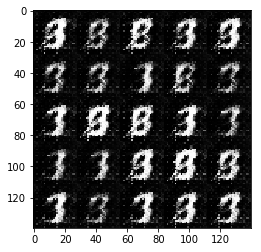

Epoch 1/2... Discriminator Loss: 0.6924... Generator Loss: 1.7201
Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 1.2589
Epoch 1/2... Discriminator Loss: 0.6890... Generator Loss: 2.0406
Epoch 1/2... Discriminator Loss: 0.8805... Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 0.7750... Generator Loss: 3.0343
Epoch 1/2... Discriminator Loss: 0.6862... Generator Loss: 2.2446
Epoch 1/2... Discriminator Loss: 0.7050... Generator Loss: 1.5646
Epoch 1/2... Discriminator Loss: 0.6904... Generator Loss: 1.8608
Epoch 1/2... Discriminator Loss: 0.6725... Generator Loss: 1.9634
Epoch 1/2... Discriminator Loss: 0.7503... Generator Loss: 1.5027


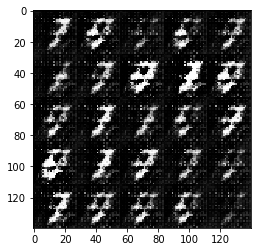

Epoch 1/2... Discriminator Loss: 0.6944... Generator Loss: 2.4081
Epoch 1/2... Discriminator Loss: 0.7639... Generator Loss: 3.0113
Epoch 1/2... Discriminator Loss: 0.6902... Generator Loss: 1.6840
Epoch 1/2... Discriminator Loss: 0.7199... Generator Loss: 1.4586
Epoch 1/2... Discriminator Loss: 0.7268... Generator Loss: 2.8491
Epoch 1/2... Discriminator Loss: 0.7352... Generator Loss: 1.6271
Epoch 1/2... Discriminator Loss: 0.8049... Generator Loss: 1.1460
Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 2.1113
Epoch 1/2... Discriminator Loss: 0.6884... Generator Loss: 1.8380
Epoch 1/2... Discriminator Loss: 0.7469... Generator Loss: 1.4906


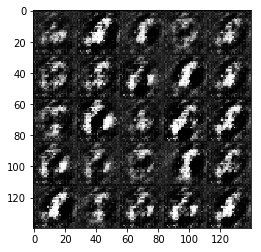

Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 1.6889
Epoch 1/2... Discriminator Loss: 0.7439... Generator Loss: 1.4344
Epoch 1/2... Discriminator Loss: 0.7046... Generator Loss: 1.7420
Epoch 1/2... Discriminator Loss: 0.7169... Generator Loss: 1.7339
Epoch 1/2... Discriminator Loss: 0.7185... Generator Loss: 1.7240
Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 0.6093
Epoch 1/2... Discriminator Loss: 0.8952... Generator Loss: 2.2296
Epoch 1/2... Discriminator Loss: 0.8357... Generator Loss: 1.5050
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 0.6528
Epoch 1/2... Discriminator Loss: 1.0050... Generator Loss: 0.8938


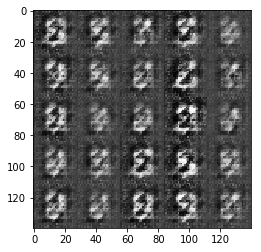

Epoch 1/2... Discriminator Loss: 0.7647... Generator Loss: 1.5931
Epoch 1/2... Discriminator Loss: 0.7863... Generator Loss: 1.7869
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.6626
Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 1.6203
Epoch 1/2... Discriminator Loss: 0.7939... Generator Loss: 1.2929
Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 1.2030
Epoch 1/2... Discriminator Loss: 0.7957... Generator Loss: 1.2741
Epoch 1/2... Discriminator Loss: 0.8774... Generator Loss: 2.4149
Epoch 1/2... Discriminator Loss: 0.7983... Generator Loss: 1.2670
Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 1.1694


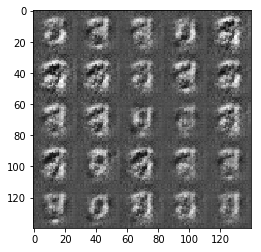

Epoch 1/2... Discriminator Loss: 0.7279... Generator Loss: 1.4293
Epoch 1/2... Discriminator Loss: 0.7364... Generator Loss: 1.4691
Epoch 1/2... Discriminator Loss: 0.8012... Generator Loss: 2.8230
Epoch 1/2... Discriminator Loss: 0.7150... Generator Loss: 2.3002
Epoch 1/2... Discriminator Loss: 0.7172... Generator Loss: 2.3071
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 1.1535
Epoch 1/2... Discriminator Loss: 0.8362... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 0.7197... Generator Loss: 1.5417
Epoch 1/2... Discriminator Loss: 0.7000... Generator Loss: 1.7127
Epoch 1/2... Discriminator Loss: 0.8029... Generator Loss: 1.1535


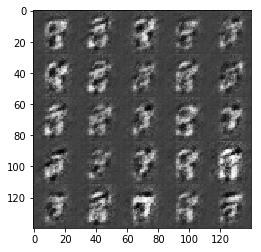

Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 1.8614
Epoch 1/2... Discriminator Loss: 0.7279... Generator Loss: 2.0844
Epoch 1/2... Discriminator Loss: 0.7347... Generator Loss: 1.4923
Epoch 1/2... Discriminator Loss: 0.8949... Generator Loss: 3.3894
Epoch 1/2... Discriminator Loss: 0.7067... Generator Loss: 1.5524
Epoch 1/2... Discriminator Loss: 0.6819... Generator Loss: 2.3453
Epoch 1/2... Discriminator Loss: 0.7384... Generator Loss: 1.5046
Epoch 1/2... Discriminator Loss: 0.7202... Generator Loss: 1.7661
Epoch 1/2... Discriminator Loss: 0.7459... Generator Loss: 1.3195
Epoch 1/2... Discriminator Loss: 0.6941... Generator Loss: 2.2606


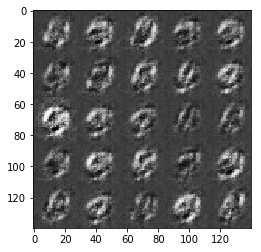

Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 1.5212
Epoch 1/2... Discriminator Loss: 0.6985... Generator Loss: 1.6436
Epoch 1/2... Discriminator Loss: 0.8152... Generator Loss: 1.1931
Epoch 2/2... Discriminator Loss: 0.7179... Generator Loss: 1.6827
Epoch 2/2... Discriminator Loss: 0.7375... Generator Loss: 1.5664
Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 1.8073
Epoch 2/2... Discriminator Loss: 0.6950... Generator Loss: 1.9966
Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 1.6251
Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 2.2645
Epoch 2/2... Discriminator Loss: 0.7290... Generator Loss: 1.4168


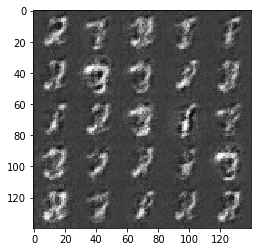

Epoch 2/2... Discriminator Loss: 0.6926... Generator Loss: 1.7401
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 1.6066
Epoch 2/2... Discriminator Loss: 0.7686... Generator Loss: 1.2426
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 1.3608
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 2.4163
Epoch 2/2... Discriminator Loss: 0.6798... Generator Loss: 2.1994
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 1.1427
Epoch 2/2... Discriminator Loss: 0.7099... Generator Loss: 2.5241
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 1.5024


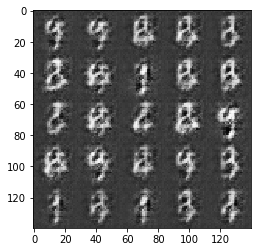

Epoch 2/2... Discriminator Loss: 0.6807... Generator Loss: 1.7788
Epoch 2/2... Discriminator Loss: 0.6884... Generator Loss: 2.1341
Epoch 2/2... Discriminator Loss: 0.7118... Generator Loss: 1.5672
Epoch 2/2... Discriminator Loss: 0.7289... Generator Loss: 2.4805
Epoch 2/2... Discriminator Loss: 0.7507... Generator Loss: 1.4215
Epoch 2/2... Discriminator Loss: 0.7092... Generator Loss: 1.5600
Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 1.3721
Epoch 2/2... Discriminator Loss: 0.7374... Generator Loss: 1.3863
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 1.5502
Epoch 2/2... Discriminator Loss: 0.6848... Generator Loss: 1.8995


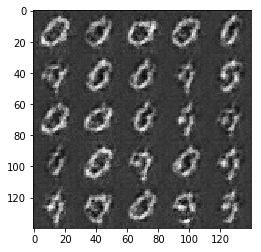

Epoch 2/2... Discriminator Loss: 0.6738... Generator Loss: 2.1648
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 2.6645
Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 2.6216
Epoch 2/2... Discriminator Loss: 0.6858... Generator Loss: 1.9133
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 2.8441
Epoch 2/2... Discriminator Loss: 0.8131... Generator Loss: 2.9777
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.0301
Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 1.8587
Epoch 2/2... Discriminator Loss: 0.8593... Generator Loss: 1.0152
Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 1.0835


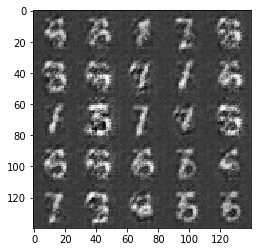

Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 1.1463
Epoch 2/2... Discriminator Loss: 0.7325... Generator Loss: 1.3933
Epoch 2/2... Discriminator Loss: 0.7068... Generator Loss: 1.5258
Epoch 2/2... Discriminator Loss: 0.6943... Generator Loss: 1.6191
Epoch 2/2... Discriminator Loss: 0.7070... Generator Loss: 1.5112
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.4439
Epoch 2/2... Discriminator Loss: 0.6835... Generator Loss: 2.0483
Epoch 2/2... Discriminator Loss: 0.6986... Generator Loss: 1.8973
Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 1.3992
Epoch 2/2... Discriminator Loss: 0.6766... Generator Loss: 1.9417


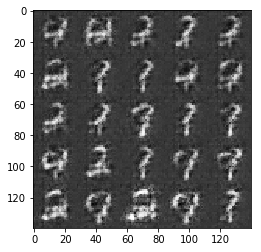

Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 1.8492
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.5783
Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 2.2543
Epoch 2/2... Discriminator Loss: 0.8101... Generator Loss: 3.1100
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 1.1350
Epoch 2/2... Discriminator Loss: 0.6902... Generator Loss: 1.6293
Epoch 2/2... Discriminator Loss: 0.6917... Generator Loss: 1.8232
Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 2.7484
Epoch 2/2... Discriminator Loss: 0.6939... Generator Loss: 2.1474
Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 2.3151


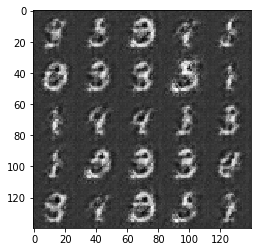

Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 2.5133
Epoch 2/2... Discriminator Loss: 0.6859... Generator Loss: 2.1633
Epoch 2/2... Discriminator Loss: 0.7033... Generator Loss: 1.6526
Epoch 2/2... Discriminator Loss: 0.6833... Generator Loss: 2.3152
Epoch 2/2... Discriminator Loss: 0.6879... Generator Loss: 1.7418
Epoch 2/2... Discriminator Loss: 0.7205... Generator Loss: 1.4168
Epoch 2/2... Discriminator Loss: 0.7793... Generator Loss: 1.1738
Epoch 2/2... Discriminator Loss: 0.6924... Generator Loss: 2.0217
Epoch 2/2... Discriminator Loss: 0.6854... Generator Loss: 1.8252
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 1.9258


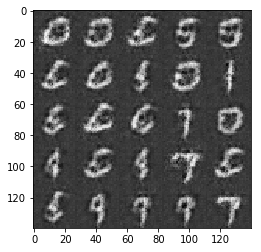

Epoch 2/2... Discriminator Loss: 0.7512... Generator Loss: 1.2486
Epoch 2/2... Discriminator Loss: 0.6894... Generator Loss: 1.6053
Epoch 2/2... Discriminator Loss: 0.7123... Generator Loss: 1.4906
Epoch 2/2... Discriminator Loss: 0.7259... Generator Loss: 2.5177
Epoch 2/2... Discriminator Loss: 0.7503... Generator Loss: 1.3230
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 1.5511
Epoch 2/2... Discriminator Loss: 0.6971... Generator Loss: 1.5916
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 1.6636
Epoch 2/2... Discriminator Loss: 0.7271... Generator Loss: 1.3615
Epoch 2/2... Discriminator Loss: 0.6752... Generator Loss: 1.8735


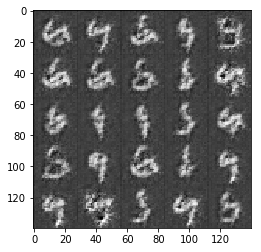

Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 0.9780
Epoch 2/2... Discriminator Loss: 0.6999... Generator Loss: 1.5948
Epoch 2/2... Discriminator Loss: 0.6741... Generator Loss: 2.0957
Epoch 2/2... Discriminator Loss: 0.7002... Generator Loss: 1.5710
Epoch 2/2... Discriminator Loss: 0.6850... Generator Loss: 1.7291
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 3.2588
Epoch 2/2... Discriminator Loss: 0.6691... Generator Loss: 2.1142
Epoch 2/2... Discriminator Loss: 0.6756... Generator Loss: 2.0892
Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.8510
Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 1.0620


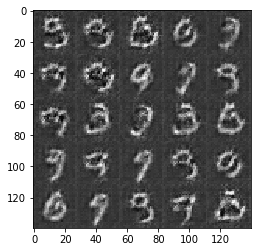

Epoch 2/2... Discriminator Loss: 0.7575... Generator Loss: 1.2545
Epoch 2/2... Discriminator Loss: 0.7254... Generator Loss: 1.3565
Epoch 2/2... Discriminator Loss: 0.6829... Generator Loss: 1.7093
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 1.7052
Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 2.4517
Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 3.8971
Epoch 2/2... Discriminator Loss: 0.6686... Generator Loss: 1.8921


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    print(mnist_dataset.shape, mnist_dataset.image_mode)
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3) RGB
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.1436
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 4.0724
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 1.8747
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 3.5500
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 3.2910
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 2.1816
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 2.4397
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 5.3263
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.6086


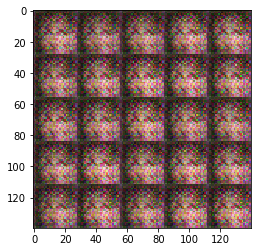

Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 1.6061
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.3403
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 2.6027
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.4072
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.9174
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 2.1905
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 2.7737
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 1.6344
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.3582


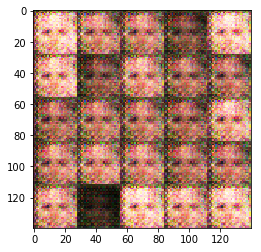

Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.7758
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 2.4451
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.6824... Generator Loss: 0.4248
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 0.9776


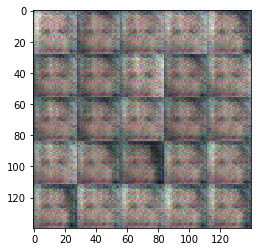

Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.6160... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.3424
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.8412


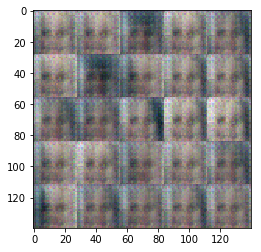

Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 1.3658
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.2576


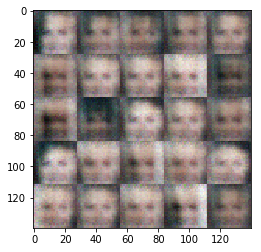

Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.3538
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.9582


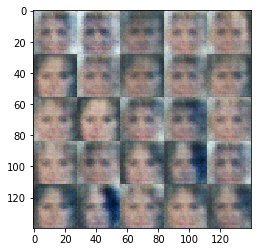

Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.4421
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 1.4314
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 1.4681
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.6303
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 2.5279
Epoch 1/1... Discriminator Loss: 1.7828... Generator Loss: 1.9347
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.0803


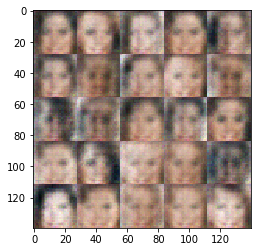

Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.5426
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.6283
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.6690
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 2.4170
Epoch 1/1... Discriminator Loss: 1.5960... Generator Loss: 0.4221
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 1.7590
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.5344
Epoch 1/1... Discriminator Loss: 2.5247... Generator Loss: 5.5171


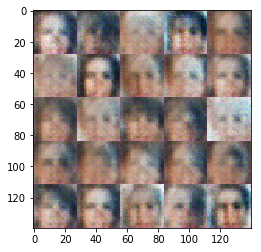

Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 2.4245
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.5895
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.7985
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 2.2715


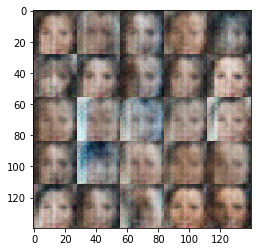

Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.3741
Epoch 1/1... Discriminator Loss: 2.2092... Generator Loss: 0.3432
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 1.3288
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 2.1765
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 1.4598
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.3758
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.9067
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.5235


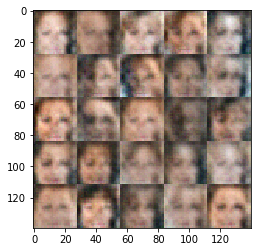

Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 1.9053
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 1.8327... Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 2.3605
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 3.2429


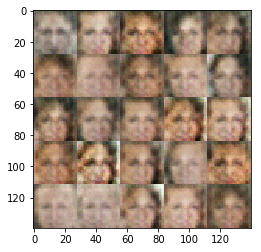

Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.9434
Epoch 1/1... Discriminator Loss: 1.9563... Generator Loss: 0.3608
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 2.2034
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 2.4520
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.3456
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 1.5002
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 2.6937
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 1.9105
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.8129


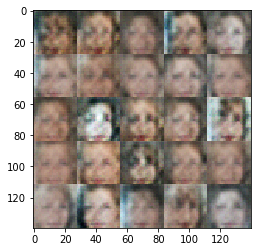

Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 2.3963... Generator Loss: 0.3419
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.7425
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.9504


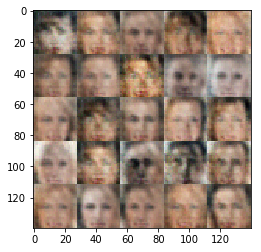

Epoch 1/1... Discriminator Loss: 1.8921... Generator Loss: 0.3844
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.7094
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 2.5398
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.3072
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.5272
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 0.9669


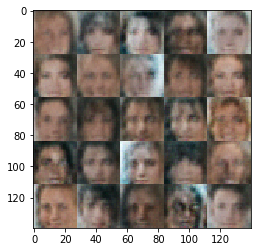

Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.2523
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 2.0565
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.5448
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 2.7583


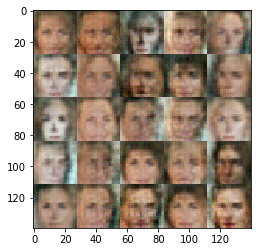

Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 2.1081
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 2.7286
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 1.5845... Generator Loss: 0.4238
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.7529


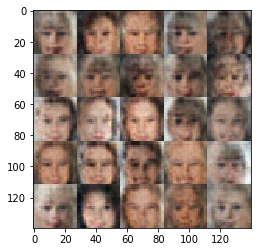

Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.1489
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.8513
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.6859
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.8091
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.5909
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.9597
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 1.6337


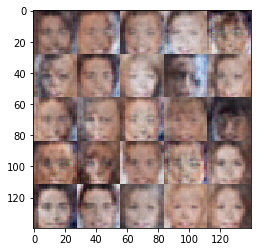

Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.2736
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 0.7036... Generator Loss: 1.7698
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.5931
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 2.4449
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 2.2622
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.1414


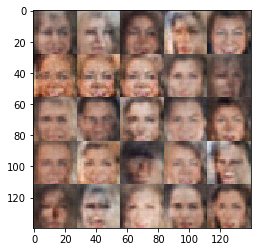

Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.8849
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 1.0998
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 2.4759
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 2.7429
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.9956


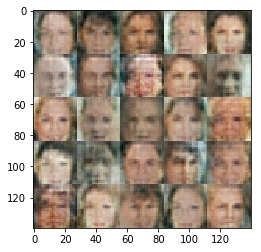

Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.6114
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.4512
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 2.8393
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 1.6463... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.3909
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.2132


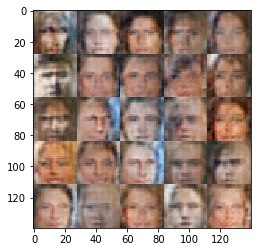

Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 2.5952
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.9909
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 1.3356
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 1.8145
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.7070
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 1.2661


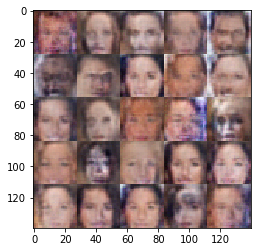

Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.9686
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.5284
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.4247
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.8571
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 1.6340
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.1712


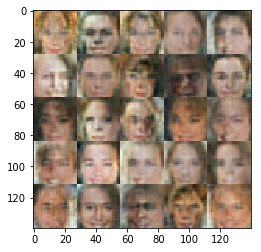

Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 3.1363
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.2781
Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 2.1458
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.1860
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 1.3050
Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 1.6972


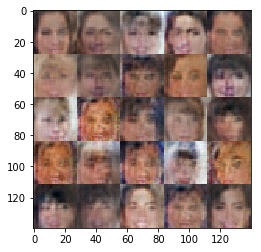

Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.5112
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.3382
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 1.3808
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.8106
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 1.2811
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.2829
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 1.5022


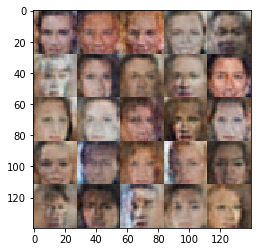

Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.9480
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.9539
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.4508
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 2.1286
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 1.7425
Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.4894
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.9368


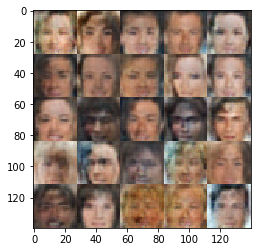

Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.9746
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.5881
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 1.7280
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.5580


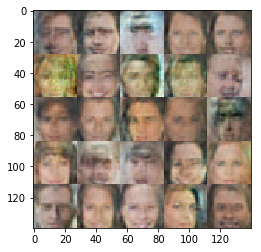

Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 2.4420
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 2.5647
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 0.8991


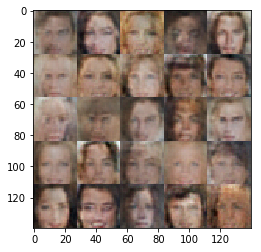

Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.7996
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.3974
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 2.5303
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.7500


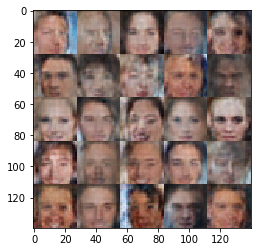

Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 2.1939
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.7162
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.7122
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.6122
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.3907
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 1.9821


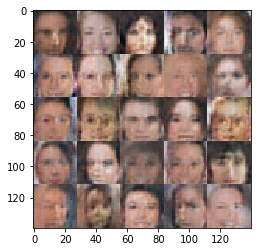

Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.5451
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.3392
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 1.8856
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.3772
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 1.3655
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.3727
Epoch 1/1... Discriminator Loss: 1.7126... Generator Loss: 0.4136


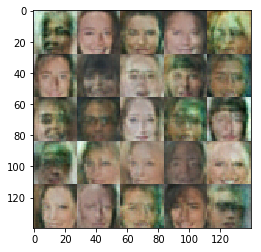

Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.8347
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 1.6527
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 2.4405
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.4108
Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 1.4242
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.4415
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 0.8840


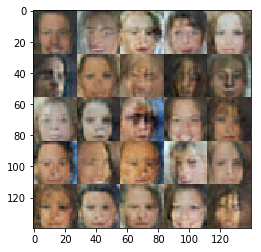

Epoch 1/1... Discriminator Loss: 1.7870... Generator Loss: 0.3853
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.8469
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.3957
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 1.0790


In [13]:
batch_size = 64         #cannot be modified / reason: ugly result
z_dim = 100             
learning_rate = 0.0002   #cannot be modified, the original is 0.002. If it is increased to 0.005, then the result is getting from good to desaster
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    print(celeba_dataset.shape, celeba_dataset.image_mode)
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.